In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb

## Homogenous Latency

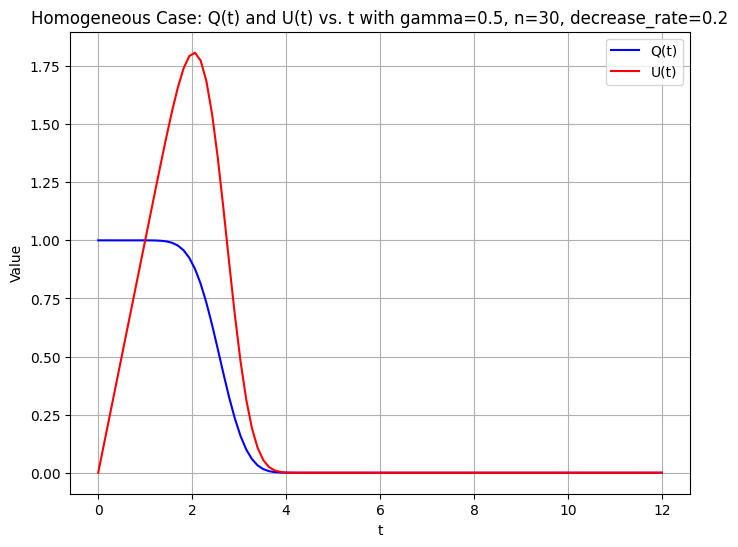

In [11]:
# -- Parameters --
k = 30            # number of attesters
gamma = 0.5       # fraction threshold
mu = 1.0          # marginal reward
t_prev = 0.0      # previous block time
alpha = 0.2       # rate at which p(t) decreases
T_max = 12.0       # max time to consider
num_points = 100  # number of points in the grid

def p(t):
    """Homogeneous success probability, linearly decreasing in t."""
    val = 1.0 - alpha*(t - t_prev)
    return max(0.0, min(1.0, val))

def Q(t):
    """Binomial-based Q(t): Probability that X >= gamma*k."""
    pt = p(t)
    threshold = int(np.ceil(gamma * k))
    total_prob = 0.0
    for r in range(threshold, k+1):
        # comb(k, r) is the binomial coefficient
        total_prob += comb(k, r) * (pt**r) * ((1-pt)**(k-r))
    return total_prob

# Prepare data
t_values = np.linspace(t_prev, T_max, num_points)
Q_values = [Q(t) for t in t_values]
U_values = [mu*(t - t_prev)*q for t, q in zip(t_values, Q_values)]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(t_values, Q_values, label='Q(t)', color='blue')
plt.plot(t_values, U_values, label='U(t)', color='red')
plt.xlabel('t')
plt.ylabel('Value')
plt.title(f'Homogeneous Case: Q(t) and U(t) vs. t with gamma={gamma}, n={k}, decrease_rate={alpha}')
plt.legend()
plt.grid(True)
# Save the plot
plt.savefig('homogeneous.png', dpi=300, bbox_inches='tight')
plt.show()


## Heterogenous Latency

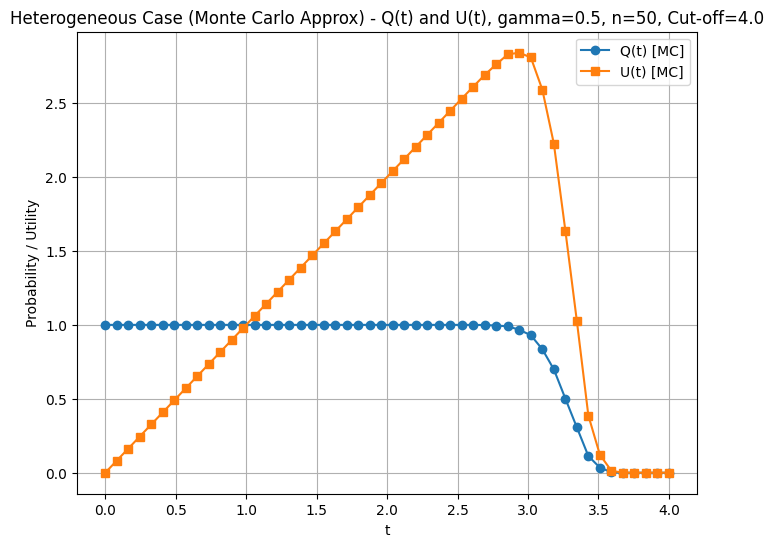

In [9]:
np.random.seed(42)

# -- Parameters --
k = 50                # number of heterogeneous attesters
gamma = 0.5
mu = 1.0
t_prev = 0.0
T_max = 4.0
n_points = 50
n_monte_carlo = 5000  # number of MC samples to estimate Q(t)

# Random deadlines D_i in [2, 5], random rates in [0.5, 1.5]
# D = np.random.uniform(2.0, T_max, k)
lam = np.random.uniform(0.5, 1.5, k)

def p_i(t, i):
    """Individual success probability for attester i."""
    if t >= T_max: #D[i]:
        return 0.0
    else: # The probability of success for attester i Pr[Exp(lam[i]) <= T_max - t]
        return 1.0 - np.exp(-lam[i]*(T_max - t))#(D[i] - t))

def Q_monte_carlo(t):
    """
    Estimate Q(t) = P(X >= gamma*k) by Monte Carlo:
    1) For each MC trial, draw X_i ~ Bernoulli(p_i(t)).
    2) Check if sum(X_i) >= gamma*k.
    3) Estimate via fraction of trials with sum(X_i) >= gamma*k.
    """
    successes = 0
    threshold = int(np.ceil(gamma * k))
    for _ in range(n_monte_carlo):
        total = 0
        for i_ in range(k):
            # Draw a Bernoulli random variable with probability p_i(t, i_)
            if np.random.rand() < p_i(t, i_): # i.e., when the attester is successful
                total += 1
        if total >= threshold:
            successes += 1
    return successes / n_monte_carlo

# Precompute Q(t) and U(t) over a grid
t_values = np.linspace(t_prev, T_max, n_points)
Q_values = []
U_values = []

for t in t_values:
    Q_t = Q_monte_carlo(t)
    Q_values.append(Q_t)
    U_values.append(mu*(t - t_prev)*Q_t)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(t_values, Q_values, label="Q(t) [MC]", marker='o')
plt.plot(t_values, U_values, label="U(t) [MC]", marker='s')
plt.xlabel("t")
plt.ylabel("Probability / Utility")
plt.title(f"Heterogeneous Case (Monte Carlo Approx) - Q(t) and U(t), gamma={gamma}, n={k}, Cut-off={T_max}")
plt.legend()
plt.grid(True)
# Save the plot
plt.savefig(f'heterogeneous_mc_{n_monte_carlo}_{k}_{T_max}.png', dpi=300, bbox_inches='tight')


## Infinite Attesters

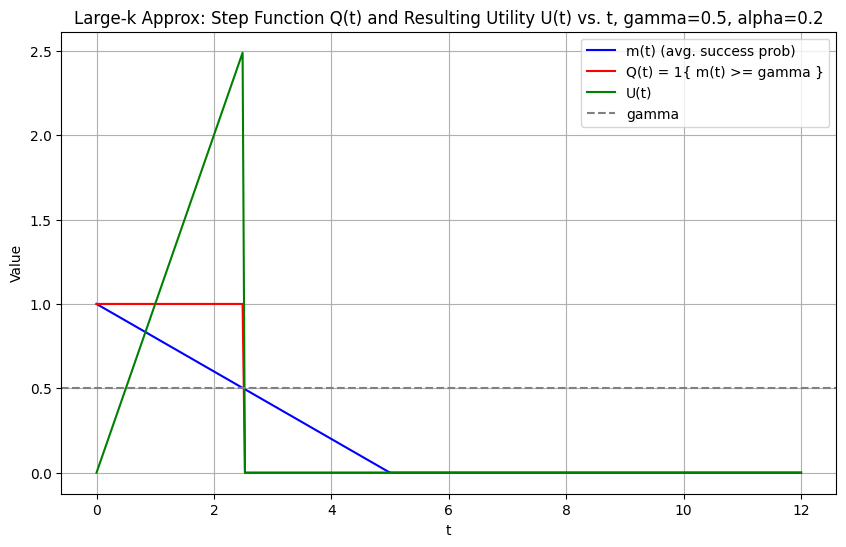

In [ ]:
# 1) Parameters
mu = 1.0
gamma = 0.5
t_prev = 0.0

# We'll define a simple piecewise linear m(t):
#    m(t) = 1 - alpha*(t - t_prev), for t in [t_prev, t_prev + 1/alpha]
#    m(t) = 0 for t >= t_prev + 1/alpha
alpha = 0.2  # slope factor, so that m(t) hits zero at t = t_prev + (1/alpha)
T_max = 12.0  # max time to plot
n_points = 300

def m_t(t):
    """
    Example decreasing function for the 'average success probability'.
    For t >= t_prev + 1/alpha, it is zero.
    """
    val = 1.0 - alpha*(t - t_prev)
    return max(0.0, val)

def Q_infinite(t):
    """
    Step function: 1 if m(t) >= gamma, else 0.
    """
    return 1.0 if m_t(t) >= gamma else 0.0

def U_infinite(t):
    """
    Utility in large-k limit: U(t) = mu*(t - t_prev)*Q_infinite(t).
    """
    return mu*(t - t_prev)*Q_infinite(t)

# 2) Build arrays for plotting
t_vals = np.linspace(t_prev, T_max, n_points)
m_vals = [m_t(t) for t in t_vals]
Q_vals = [Q_infinite(t) for t in t_vals]
U_vals = [U_infinite(t) for t in t_vals]

# 3) Plot
plt.figure(figsize=(10,6))

# Plot m(t)
plt.plot(t_vals, m_vals, label='m(t) (avg. success prob)', color='blue')

# Plot Q_infinite(t)
plt.plot(t_vals, Q_vals, label='Q(t) = 1{ m(t) >= gamma }', color='red')

# Plot U_infinite(t)
plt.plot(t_vals, U_vals, label='U(t)', color='green')

# Draw a horizontal line at gamma for reference
plt.axhline(y=gamma, color='gray', linestyle='--', label='gamma')

plt.xlabel('t')
plt.ylabel('Value')
plt.title(f'Large-k Approx: Step Function Q(t) and Resulting Utility U(t) vs. t, gamma={gamma}')
plt.grid(True)
plt.legend()
# Save the plot
plt.savefig('large_k_approx.png', dpi=300, bbox_inches='tight')
plt.show()
